In [157]:
import argparse
import glob
import json
import os
from omegaconf import OmegaConf
from PIL import Image
import random
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from archs.diffusion_extractor import DiffusionExtractor
from archs.aggregation_network import AggregationNetwork
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import process_image

from archs.detectron2.resnet import ResNet, BottleneckBlock
from diffusers import DDIMScheduler
from archs.stable_diffusion.diffusion import (
    init_models, 
    get_tokens_embedding,
    generalized_steps,
    collect_and_resize_feats
)
from archs.stable_diffusion.resnet import init_resnet_func

In [158]:
device = "cuda"
guidance_scale = 7.5
prompt = "A raccoon playing chess with oversized pieces."
negative_prompt = ""

In [159]:
from diffusers import StableDiffusionPipeline

In [160]:
# Load the stable diffusion pipeline, which includes UNet, VAE, and tokenizer
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
unet = pipeline.unet  # Access the UNet model directly
unet.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [161]:
from transformers import CLIPProcessor, CLIPModel

# Load the pre-trained CLIP model and tokenizer
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_tokenizer = CLIPProcessor.from_pretrained(model_name)

# Move the model to the desired device (e.g., "cuda" for GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [162]:
scheduler = DDIMScheduler(
    beta_start=0.00085,         # Initial beta value for diffusion
    beta_end=0.012,             # Final beta value for diffusion
    beta_schedule="scaled_linear",  # Beta schedule type, options include "linear", "scaled_linear", etc.
    num_train_timesteps=1000    # Number of timesteps used during training
)

In [163]:
def get_cond_embedding(prompt, clip_model, clip_tokenizer, device, batch_size):
    # Get the token embeddings for the prompt using the CLIP model and tokenizer
    with torch.no_grad():
            # Tokenize and get embeddings for the prompt
            inputs = clip_tokenizer(text=prompt, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device

            text_embeddings = clip_model.get_text_features(**inputs)
            # Expand the embedding to match the batch size
            cond_embedding = text_embeddings.expand((batch_size, *text_embeddings.shape[1:]))
    return cond_embedding

In [164]:
cond = get_cond_embedding(prompt, clip_model, clip_tokenizer, device=device, batch_size=1)
cond = cond.unsqueeze(1)
print("Conditional embedding shape:", cond.shape)
print("Scheduler timesteps:", scheduler.num_train_timesteps)
negative_prompt = ""
uncond = get_cond_embedding(negative_prompt, clip_model, clip_tokenizer, device=device, batch_size=1)
uncond = uncond.unsqueeze(1)
print("Unconditional embedding shape:", uncond.shape)
#end_timestep = int(0.8 * diffusion_extractor.scheduler.config.num_train_timesteps)

Conditional embedding shape: torch.Size([1, 1, 512])
Scheduler timesteps: 1000
Unconditional embedding shape: torch.Size([1, 1, 512])


c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [165]:
def run_generation(latent, unet, scheduler, cond, uncond, guidance_scale=-1, min_i=None, max_i=None):
    # Ensure correct dtypes
    latent = latent.half()
    cond = cond.half()
    uncond = uncond.half()

    # Generate x as needed
    x = torch.randn_like(latent)
    print("x:", x.shape)

    # Adjusted code to match generalized_steps output
    result= generalized_steps(
        x=x,
        model=unet, 
        scheduler=scheduler, 
        run_inversion=False, 
        guidance_scale=guidance_scale, 
        conditional=cond, 
        unconditional=uncond, 
        min_i=min_i,
        max_i=max_i
    )
    print("result:", result)
    # Unpack result based on actual output from generalized_steps
    if isinstance(result, tuple) and len(result) == 2:
        xs, additional_output = result
    elif isinstance(result, tuple) and len(result) == 3:
        xs, additional_output, another_value = result  # Adjust if three values
    else:
        xs = result  # Single value case

In [185]:
import torch.nn as nn
import torch.nn.functional as F

def run_generation_1(latent, unet, scheduler, cond, uncond, guidance_scale=-1, min_i=None, max_i=None):
    # Ensure correct dtypes and dimensions
    dtype = torch.float16
    latent = latent.to(dtype)
    cond = cond.to(dtype)
    uncond = uncond.to(dtype)

     # Debug print for shapes
    print("Initial Latent shape:", latent.shape)
    print("Initial Conditional shape:", cond.shape)
    print("Initial Unconditional shape:", uncond.shape)

    # Expand cond and uncond to 4D for interpolation if needed
    if cond.dim() == 3:
        cond = cond.unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, seq_len, embedding_dim, 1, 1]
        uncond = uncond.unsqueeze(-1).unsqueeze(-1)

     # Adjust cond and uncond dimensions if needed
    target_shape = latent.shape[-2:]  # Match spatial dimensions
    if cond.shape[-2:] != target_shape:
        cond = F.interpolate(cond, size=target_shape, mode="bilinear", align_corners=False)
        uncond = F.interpolate(uncond, size=target_shape, mode="bilinear", align_corners=False)
    

    print("Adjusted Conditional shape:", cond.shape)
    print("Adjusted Unconditional shape:", uncond.shape)


    # # Add a sequence dimension if cond and uncond are 2D
    # if cond.dim() == 2:
    #     cond = cond.unsqueeze(1)  # Shape (batch_size, 1, 512)
    # if uncond.dim() == 2:
    #     uncond = uncond.unsqueeze(1)  # Shape (batch_size, 1, 512)

    # # Project `cond` and `uncond` to match the model's expected embedding dimension
    # projection_layer = nn.Linear(512, 768).to(cond.device).to(dtype)  # Adjust 512 to the initial embedding dim, 768 to target dim
    # cond = projection_layer(cond)
    # uncond = projection_layer(uncond)

    # # Print to confirm shapes
    # print("Latent shape:", latent.shape)
    # print("Conditional shape:", cond.shape)
    # print("Unconditional shape:", uncond.shape)

    # Run the diffusion steps
    xs = generalized_steps(
        x=latent,
        model=unet, 
        scheduler=scheduler, 
        run_inversion=False, 
        guidance_scale=guidance_scale, 
        conditional=cond, 
        unconditional=uncond, 
        min_i=min_i,
        max_i=max_i
    )
    return xs


In [189]:
config_path = "configs/real.yaml"
config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)
weights = torch.load(config["weights_path"], map_location="cpu")
config.update(weights["config"])
if config.get("flip_timesteps", False):
    config["save_timestep"] = config["save_timestep"][::-1]


idxs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution = 64
save_timestep = [0, 250, 500, 750, 1000]


diffusion_extractor = DiffusionExtractor(config, device)
print(diffusion_extractor)
end_timestep = int(0.8 * scheduler.config.num_train_timesteps) 
extractor_fn = lambda latents:run_generation_1(
    latents,
    unet=diffusion_extractor.unet,
    scheduler=diffusion_extractor.scheduler,
    cond=cond,  # Use previously defined `cond`
    uncond=uncond,  # Use previously defined `uncond`
    guidance_scale=guidance_scale,
    max_i=end_timestep
)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


In [180]:
from functools import partial
from archs.diffusion_extractor import DiffusionExtractor

In [181]:
def get_feats(latents, extractor_fn, preview_mode):
    idxs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
    output_resolution = 64
    save_timestep = [0, 250, 500, 750, 1000]

    if not preview_mode: 
        init_resnet_func(unet, save_hidden=True, reset=True, idxs=idxs, save_timestep=save_timestep)
    
    # Expect a single output from extractor_fn
    outputs = extractor_fn(latents) if isinstance(extractor_fn(latents), tuple) else (extractor_fn(latents), None)

    if not preview_mode:
        feats = []
        for timestep in save_timestep:
            timestep_feats = collect_and_resize_feats(unet, idxs, timestep, output_resolution)
            feats.append(timestep_feats)
        feats = torch.stack(feats, dim=1)
        init_resnet_func(unet, reset=True)
    else:
        feats = None
    
    return feats, outputs

In [182]:
from functools import partial
from archs.diffusion_extractor import DiffusionExtractor

In [183]:
config_path = "configs/real.yaml"
config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)
weights = torch.load(config["weights_path"], map_location="cpu")
config.update(weights["config"])
if config.get("flip_timesteps", False):
    config["save_timestep"] = config["save_timestep"][::-1]


idxs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution = 64
save_timestep = [0, 250, 500, 750, 1000]


diffusion_extractor = DiffusionExtractor(config, device)
print(diffusion_extractor)


latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)
print("latents:", latents.shape)


end_timestep = int(0.8 * scheduler.config.num_train_timesteps) 
extractor_fn = lambda latents:run_generation_1(
    latents,
    unet=diffusion_extractor.unet,
    scheduler=diffusion_extractor.scheduler,
    cond=cond,  # Use previously defined `cond`
    uncond=uncond,  # Use previously defined `uncond`
    guidance_scale=guidance_scale,
    max_i=end_timestep
)

# if preview_mode:
#     extractor_fn = lambda latents: run_generation(latents, guidance_scale, max_i=end_timestep)
# else:
#     extractor_fn = lambda latents: run_generation(latents, guidance_scale)

##end_timestep = int(0.8 * scheduler.config.num_train_timesteps) 
# extractor_fn = lambda latents:run_generation(
#     latents,
#     unet=diffusion_extractor.unet,
#     scheduler=diffusion_extractor.scheduler,
#     cond=cond.unsqueeze(1),  # Use previously defined `cond`
#     uncond=uncond.unsqueeze(1),  # Use previously defined `uncond`
#     guidance_scale=guidance_scale,
#     max_i=end_timestep
# )
print("extractor_fn:",extractor_fn)

print("Latents shape:", latents.shape)
print("UNet in_channels:", diffusion_extractor.unet.in_channels)
print("Device:", diffusion_extractor.device)
print("Scheduler:", diffusion_extractor.scheduler)
print("Conditional embedding shape:", cond.shape)
print("Unconditional embedding shape:", uncond.shape)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 
latents: torch.Size([2, 4, 64, 64])
extractor_fn: <function <lambda> at 0x000002A6FCFAB2E0>
Latents shape: torch.Size([2, 4, 64, 64])
UNet in_channels: 4
Device: cuda
Scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

Conditional embedding shape: torch.Size([1, 1, 512])
Unconditional embedding shape: torch.Size([1, 1, 512])


C:\Users\saqib\AppData\Local\Temp\ipykernel_2744\1372406067.py:19: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)
C:\Users\saqib\AppData\Local\Temp\ipykernel_2744\1372406067.py:52: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  print("UNet in_channels:", diffusion_extractor.unet.in_channels)


In [62]:
class DiffusionExtractor:
    """
    Module for running either the generation or inversion process 
    and extracting intermediate feature maps.
    """
    def __init__(self, config, device):
        self.device = device
        self.scheduler = DDIMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            num_train_timesteps=1000,
        )
        self.num_timesteps = config["num_timesteps"]
        self.scheduler.set_timesteps(self.num_timesteps)
        self.generator = torch.Generator(self.device).manual_seed(config.get("seed", 0))
        self.batch_size = config.get("batch_size", 1)

        self.unet, self.vae, self.clip, self.clip_tokenizer = init_models(device=self.device, model_id=config["model_id"])
        self.prompt = config.get("prompt", "")
        self.negative_prompt = config.get("negative_prompt", "")
        self.change_cond(self.prompt, "cond")
        self.change_cond(self.negative_prompt, "uncond")
        
        self.diffusion_mode = config.get("diffusion_mode", "generation")
        if "idxs" in config and config["idxs"] is not None:
            self.idxs = config["idxs"]
        else:
            self.idxs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
        self.output_resolution = config["output_resolution"]

        # Note that save_timestep is in terms of number of generation steps
        # save_timestep = 0 is noise, save_timestep = T is a clean image
        # generation saves as [0...T], inversion saves as [T...0]
        self.save_timestep = config.get("save_timestep", [])

        print(f"diffusion_mode: {self.diffusion_mode}")   #diffusion_mode: inversion
        print(f"idxs: {self.idxs}") #idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
        print(f"output_resolution: {self.output_resolution}")  #output_resolution: 64
        print(f"prompt: {self.prompt}")   #prompt:""
        print(f"negative_prompt: {self.negative_prompt}")  #negative_prompt:""

    def change_cond(self, prompt, cond_type="cond"):
        with torch.no_grad():
            with torch.autocast("cuda"):
                _, new_cond = get_tokens_embedding(self.clip_tokenizer, self.clip, self.device, prompt)
                new_cond = new_cond.expand((self.batch_size, *new_cond.shape[1:]))
                new_cond = new_cond.to(self.device)
                if cond_type == "cond":
                    self.cond = new_cond
                    self.prompt = prompt
                elif cond_type == "uncond":
                    self.uncond = new_cond
                    self.negative_prompt = prompt
                else:
                    raise NotImplementedError

    def run_generation(self, latent, guidance_scale=-1, min_i=None, max_i=None):
        xs = generalized_steps(
            latent,
            self.unet, 
            self.scheduler, 
            run_inversion=False, 
            guidance_scale=guidance_scale, 
            conditional=self.cond, 
            unconditional=self.uncond, 
            min_i=min_i,
            max_i=max_i
        )
        return xs
    
    def run_inversion(self, latent, guidance_scale=-1, min_i=None, max_i=None):
        xs = generalized_steps(
            latent, 
            self.unet, 
            self.scheduler, 
            run_inversion=True, 
            guidance_scale=guidance_scale, 
            conditional=self.cond, 
            unconditional=self.uncond,
            min_i=min_i,
            max_i=max_i
        )
        return xs

    def get_feats(self, latents, extractor_fn, preview_mode=False):
        # returns feats of shape [batch_size, num_timesteps, channels, w, h]
        if not preview_mode:
            init_resnet_func(self.unet, save_hidden=True, reset=True, idxs=self.idxs, save_timestep=self.save_timestep)
        outputs = extractor_fn(latents)
        if not preview_mode:
            feats = []
            for timestep in self.save_timestep:
                timestep_feats = collect_and_resize_feats(self.unet, self.idxs, timestep, self.output_resolution)
                feats.append(timestep_feats)
            feats = torch.stack(feats, dim=1)
            init_resnet_func(self.unet, reset=True)
        else:
            feats = None
        return feats, outputs

    def latents_to_images(self, latents):
        latents = latents.to(self.device)
        latents = latents / 0.18215
        images = self.vae.decode(latents.to(self.vae.dtype)).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (images * 255).round().astype("uint8")
        return [Image.fromarray(image) for image in images]

    def forward(self, images=None, latents=None, guidance_scale=-1, preview_mode=False):
        if images is None:
            if latents is None:
                latents = torch.randn((self.batch_size, self.unet.in_channels, 512 // 8, 512 // 8), device=self.device, generator=self.generator)
                print("latents for generation:", latents.shape)
            if self.diffusion_mode == "generation":
                if preview_mode:
                    extractor_fn = lambda latents: self.run_generation(latents, guidance_scale, max_i=self.end_timestep)
                    print("extractor_fn for generation:", extractor_fn)
                else:
                    extractor_fn = lambda latents: self.run_generation(latents, guidance_scale)
            elif self.diffusion_mode == "inversion":
                raise NotImplementedError
        else:
            images = torch.nn.functional.interpolate(images, size=512, mode="bilinear")
            plt.imshow(images)
            latents = self.vae.encode(images).latent_dist.sample(generator=None) * 0.18215
            print("latents for inversion:", latents.shape)
            if self.diffusion_mode == "inversion":
                extractor_fn = lambda latents: self.run_inversion(latents, guidance_scale)
                print("extractor_fn for inversion:", extractor_fn)
            elif self.diffusion_mode == "generation":
                raise NotImplementedError
        
        with torch.no_grad():
            with torch.autocast("cuda"):
                return self.get_feats(latents, extractor_fn, preview_mode=preview_mode)

In [66]:
class AggregationNetwork(nn.Module):
    """
    Module for aggregating feature maps across time and space.
    Design inspired by the Feature Extractor from ODISE (Xu et. al., CVPR 2023).
    https://github.com/NVlabs/ODISE/blob/5836c0adfcd8d7fd1f8016ff5604d4a31dd3b145/odise/modeling/backbone/feature_extractor.py
    """
    def __init__(
            self, 
            feature_dims, 
            device, 
            projection_dim=384, 
            num_norm_groups=32,
            num_res_blocks=1, 
            save_timestep=[],
            num_timesteps=None,
            timestep_weight_sharing=False
        ):
        super().__init__()
        self.bottleneck_layers = nn.ModuleList()
        self.feature_dims = feature_dims    
        # For CLIP symmetric cross entropy loss during training
        self.logit_scale = torch.ones([]) * np.log(1 / 0.07)
        self.device = device
        self.save_timestep = save_timestep

        self.mixing_weights_names = []
        for l, feature_dim in enumerate(self.feature_dims):
            bottleneck_layer = nn.Sequential(
                *ResNet.make_stage(
                    BottleneckBlock,
                    num_blocks=num_res_blocks,
                    in_channels=feature_dim,
                    bottleneck_channels=projection_dim // 4,
                    out_channels=projection_dim,
                    norm="GN",
                    num_norm_groups=num_norm_groups
                )
            )
            self.bottleneck_layers.append(bottleneck_layer)
            for t in save_timestep:
                # 1-index the layer name following prior work
                self.mixing_weights_names.append(f"timestep-{save_timestep}_layer-{l+1}")
        
        self.bottleneck_layers = self.bottleneck_layers.to(device)
        mixing_weights = torch.ones(len(self.bottleneck_layers) * len(save_timestep))
        self.mixing_weights = nn.Parameter(mixing_weights.to(device))

    def forward(self, batch):
        """
        Assumes batch is shape (B, C, H, W) where C is the concatentation of all layer features.
        """
        output_feature = None
        start = 0
        mixing_weights = torch.nn.functional.softmax(self.mixing_weights)
        for i in range(len(mixing_weights)):
            # Share bottleneck layers across timesteps
            bottleneck_layer = self.bottleneck_layers[i % len(self.feature_dims)]
            # Chunk the batch according the layer
            # Account for looping if there are multiple timesteps
            end = start + self.feature_dims[i % len(self.feature_dims)]
            feats = batch[:, start:end, :, :]
            start = end
            # Downsample the number of channels and weight the layer
            bottlenecked_feature = bottleneck_layer(feats)
            bottlenecked_feature = mixing_weights[i] * bottlenecked_feature
            if output_feature is None:
                output_feature = bottlenecked_feature
            else:
                output_feature += bottlenecked_feature
        return output_feature

In [67]:
def load_models(config_path, device="cuda"):
    config = OmegaConf.load(config_path)
    config = OmegaConf.to_container(config, resolve=True)
    print("config:", config)
    weights = torch.load(config["weights_path"], map_location="cpu")
    print("weights:", weights)
    config.update(weights["config"])
    if config.get("flip_timesteps", False):
        config["save_timestep"] = config["save_timestep"][::-1]
    
    # dims is the channel dim for each layer (12 dims for Layers 1-12)
    # idxs is the (block, sub-block) index for each layer (12 idxs for Layers 1-12)
    diffusion_extractor = DiffusionExtractor(config, device)
    dims = collect_dims(diffusion_extractor.unet, idxs=diffusion_extractor.idxs)
    aggregation_network = AggregationNetwork(
        projection_dim=config["projection_dim"],
        feature_dims=dims,
        device=device,
        save_timestep=config["save_timestep"],
        num_timesteps=config["num_timesteps"]
    )
    aggregation_network.load_state_dict(weights["aggregation_network"])
    return config, diffusion_extractor, aggregation_network

In [68]:
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path)

config: {'weights_path': 'weights/aggregation_network.pt', 'diffusion_mode': 'inversion', 'output_resolution': 64, 'batch_size': 2, 'prompt': '', 'negative_prompt': '', 'guidance_scale': -1, 'flip_timesteps': False}
weights: {'step': 3000, 'config': {'model_id': 'runwayml/stable-diffusion-v1-5', 'timestep': 0, 'num_timesteps': 50, 'save_timestep': [49, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0], 'lr': 0.001, 'projection_dim': 384}, 'optimizer_state_dict': {'state': {0: {'step': 3001, 'exp_avg': tensor([ 4.2721e-04,  4.8024e-04,  2.0545e-03, -2.7395e-03,  2.3386e-03,
        -2.0912e-05,  4.3602e-03,  1.8651e-03,  1.8179e-03, -4.1935e-04,
         2.6878e-03,  1.2204e-05,  1.5369e-03,  1.5610e-03,  5.4536e-03,
        -2.5376e-02, -6.5591e-04, -1.1755e-03, -9.3819e-03,  3.8213e-03,
         6.8692e-04, -2.2200e-03,  1.2832e-03, -2.8969e-04,  3.4672e-03,
         4.3243e-03,  7.9774e-03, -2.6992e-02, -1.2022e-02, -3.6659e-03,
         8.0251e-04,  1.6073e-03, -6.0141e-04, -1.0463e-03,  1.0453

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


In [54]:
def extract_hyperfeats(config, diffusion_extractor, aggregation_network, images_or_prompts, save_root, device="cuda", load_size=(512, 512)):
  b = config["batch_size"]
  w = h = config["output_resolution"]
  meta_file = []
  for i in tqdm(range(0, len(images_or_prompts), b)):
    with torch.inference_mode():
      with torch.autocast("cuda"):
        if config["diffusion_mode"] == "inversion":
            imgs, save_names = [], []
            for path in images_or_prompts[i:i+b]:
                img_pil = Image.open(path).convert("RGB")
                img, _ =  process_image(img_pil, res=load_size)
                img = img.to(device)
                imgs.append(img)
                save_names.append(os.path.basename(path).split(".")[0])
            imgs = torch.vstack(imgs)
            feats, _ = diffusion_extractor.forward(imgs)
            diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
            ################
            # Number of channels to plot (e.g., plot 9 channels)
            num_channels_to_plot = 9

            # Set up the plot grid (3 rows, 3 columns for example)
            fig, axes = plt.subplots(3, 3, figsize=(12, 12))

            # Flatten the axes array for easier indexing
            axes = axes.flatten()

            # Plot each of the first 9 channels
            for i in range(num_channels_to_plot):
              selected_feature_map = diffusion_hyperfeats[0, i, :, :]
              axes[i].imshow(selected_feature_map.detach().cpu().numpy(), cmap='viridis')
              axes[i].axis('off')
              axes[i].set_title(f"Channel {i}")

            plt.tight_layout()
            plt.show()
            ###########################
           
        elif config["diffusion_mode"] == "generation":
          prompt = images_or_prompts[i]
          negative_prompt = config["negative_prompt"]
          diffusion_extractor.change_cond(prompt, "cond")
          diffusion_extractor.change_cond(negative_prompt, "uncond")
          latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)
          feats, outputs = diffusion_extractor.forward(latents=latents, guidance_scale=config["guidance_scale"])
          diffusion_hyperfeats = aggregation_network(torch.flip(feats, dims=(1,)).float().view(b, -1, w, h))
           
          save_names = []
          for img in diffusion_extractor.latents_to_images(outputs[-1]):
            hash_name = str(random.getrandbits(32))
            img.save(f"{save_root}/{hash_name}.png")
            save_names.append(hash_name)
            meta_file.append({"source_path": f"{hash_name}.png", "prompt": prompt})
    for j, img_hyperfeats in enumerate(diffusion_hyperfeats):
      torch.save(img_hyperfeats.detach().cpu(), f"{save_root}/{save_names[j]}.pt")
    json.dump(meta_file, open(f"{save_root}/meta.json", "w"))


In [55]:
def pad_to_batch_size(items, batch_size):
    remainder = len(items) % batch_size
    if remainder == 0:
        return items

    padding_length = batch_size - remainder
    padding = items[-1:] * padding_length  # Duplicate the last element
    padded_items = items + padding
    return padded_items

In [56]:
images_or_prompts_path = "annotations/spair_71k_test-6.json"
save_root = "hyperfeatures"
if not os.path.exists(save_root):
    os.makedirs(save_root, exist_ok=True)
image_root = "assets/spair/images"

batch_size: 2


  0%|          | 0/6 [00:00<?, ?it/s]

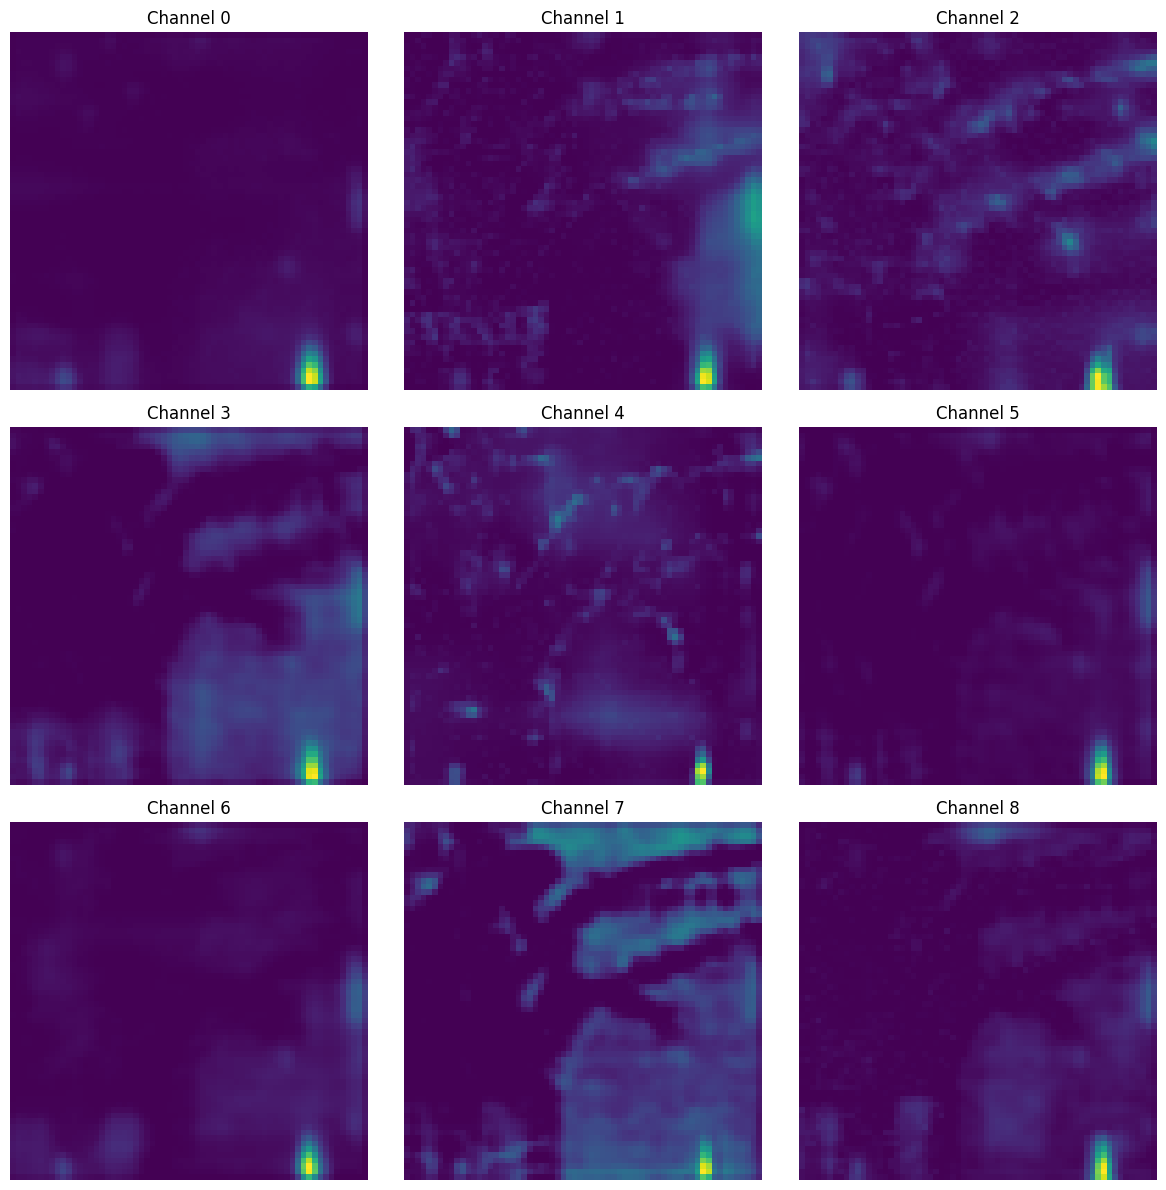

 17%|█▋        | 1/6 [00:02<00:12,  2.42s/it]

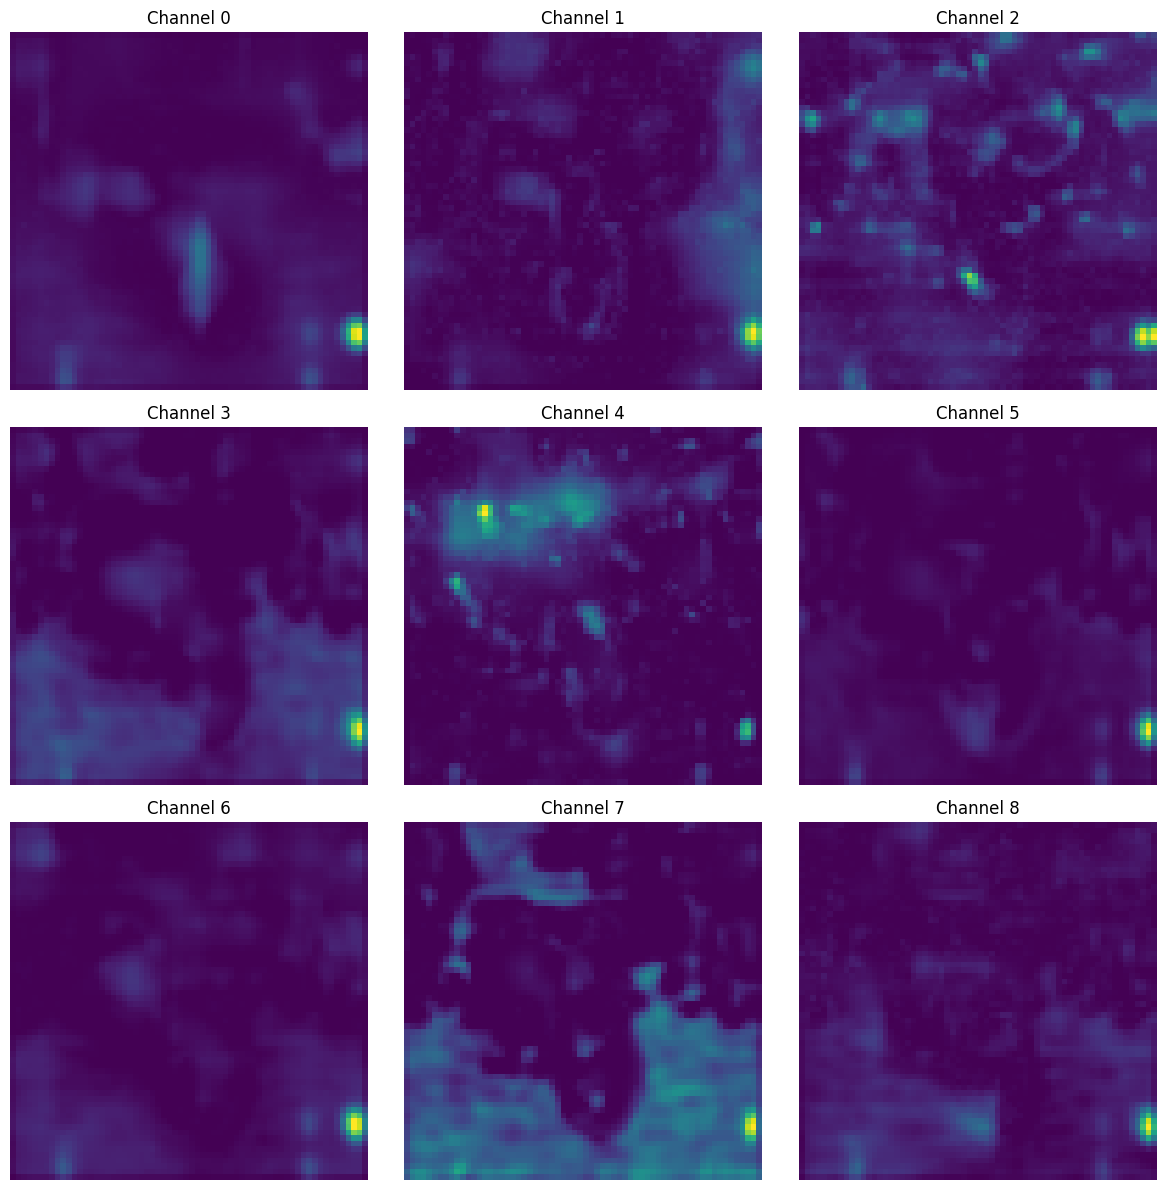

 33%|███▎      | 2/6 [00:04<00:09,  2.29s/it]

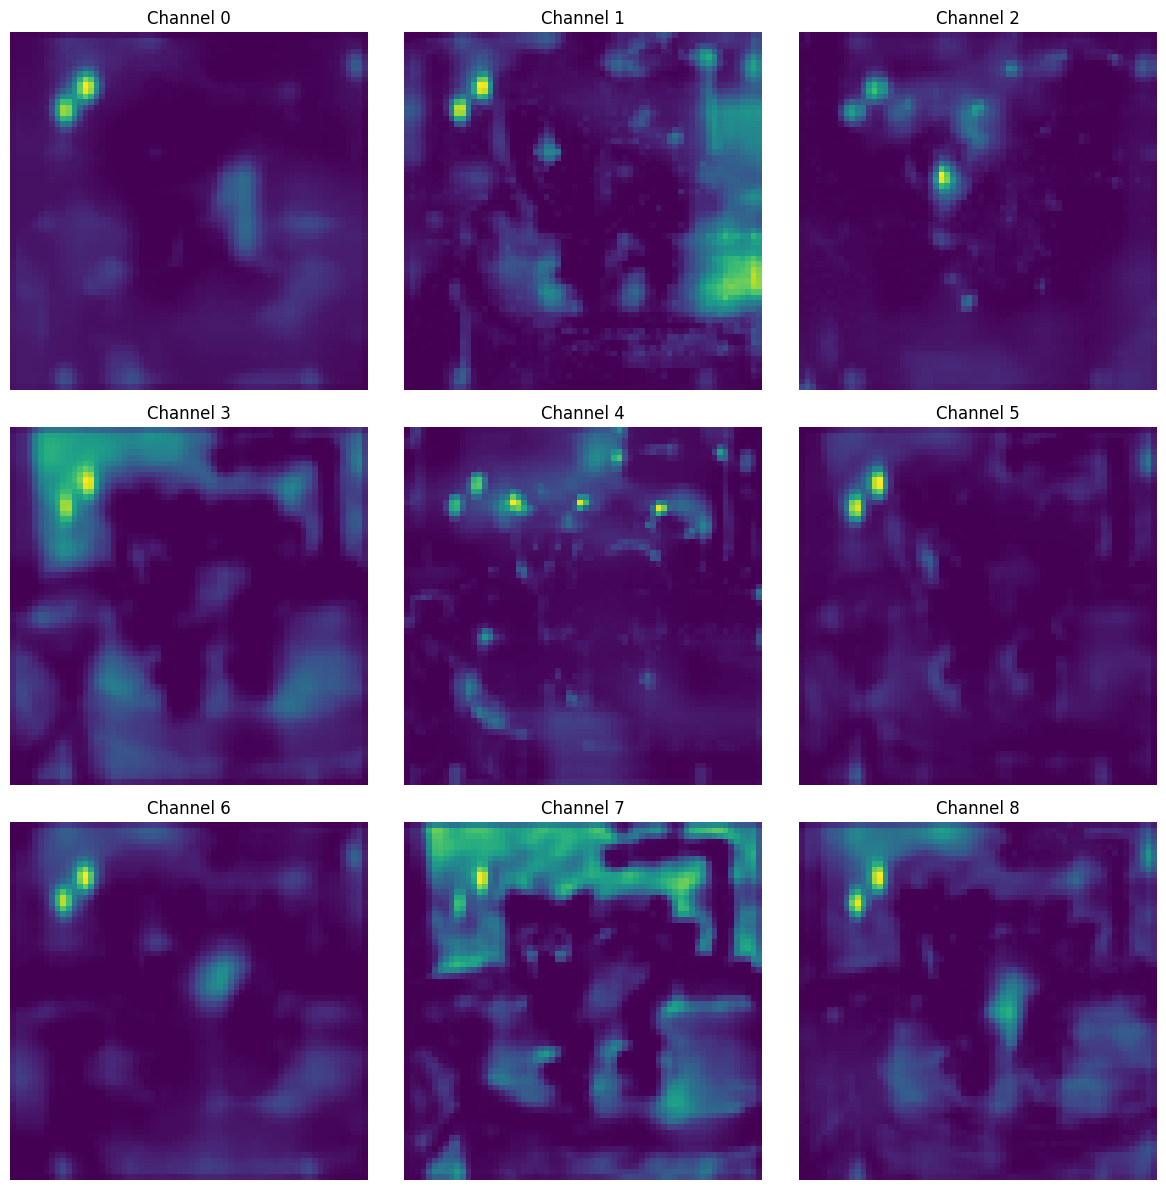

 50%|█████     | 3/6 [00:06<00:06,  2.24s/it]

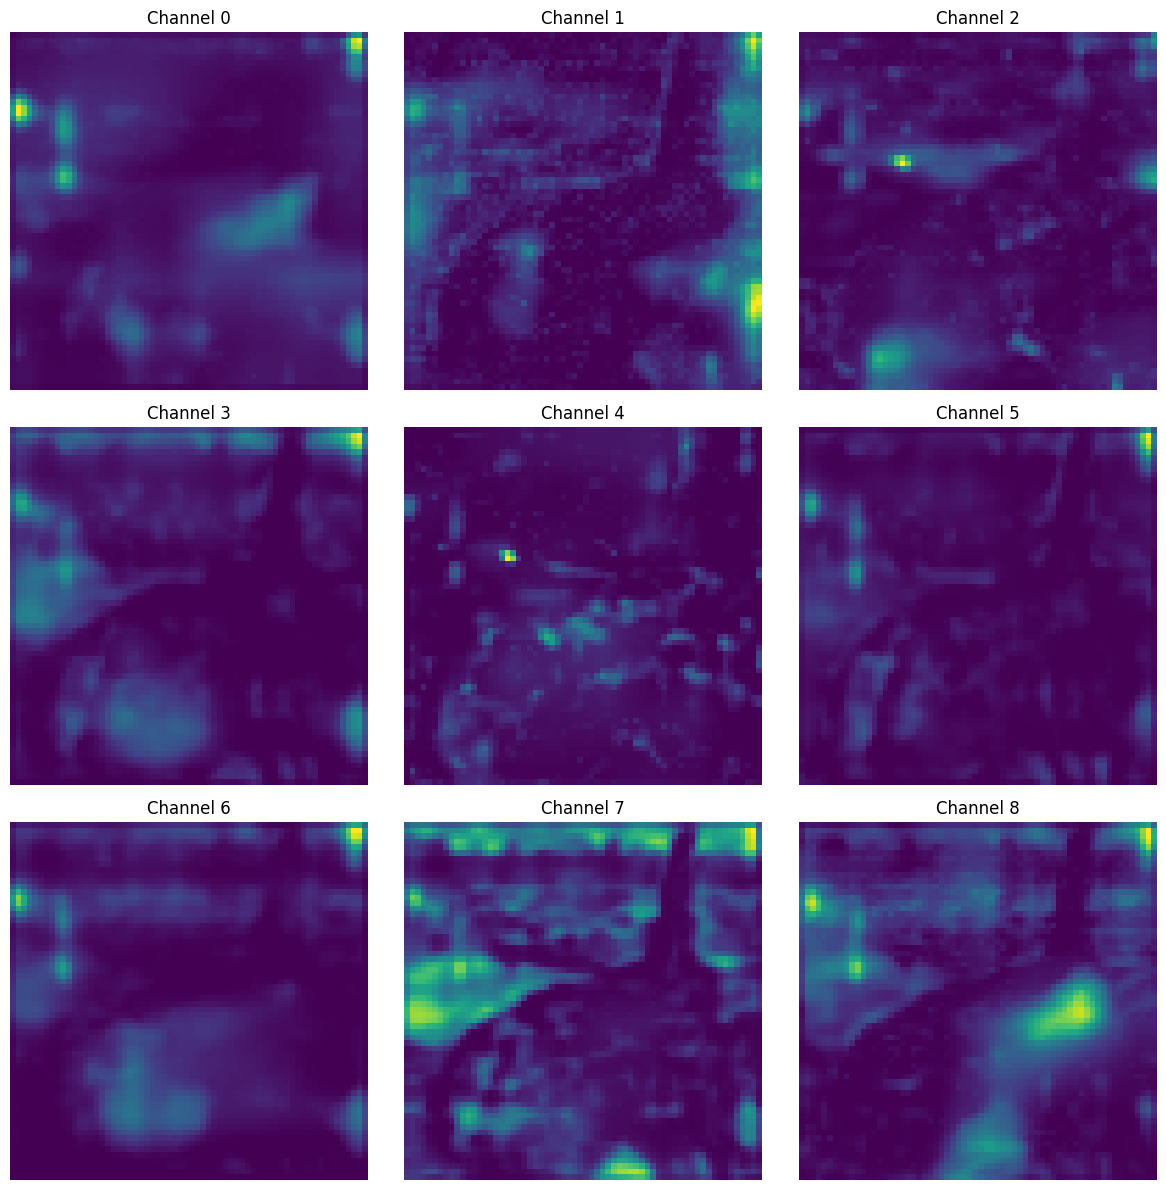

 67%|██████▋   | 4/6 [00:09<00:04,  2.23s/it]

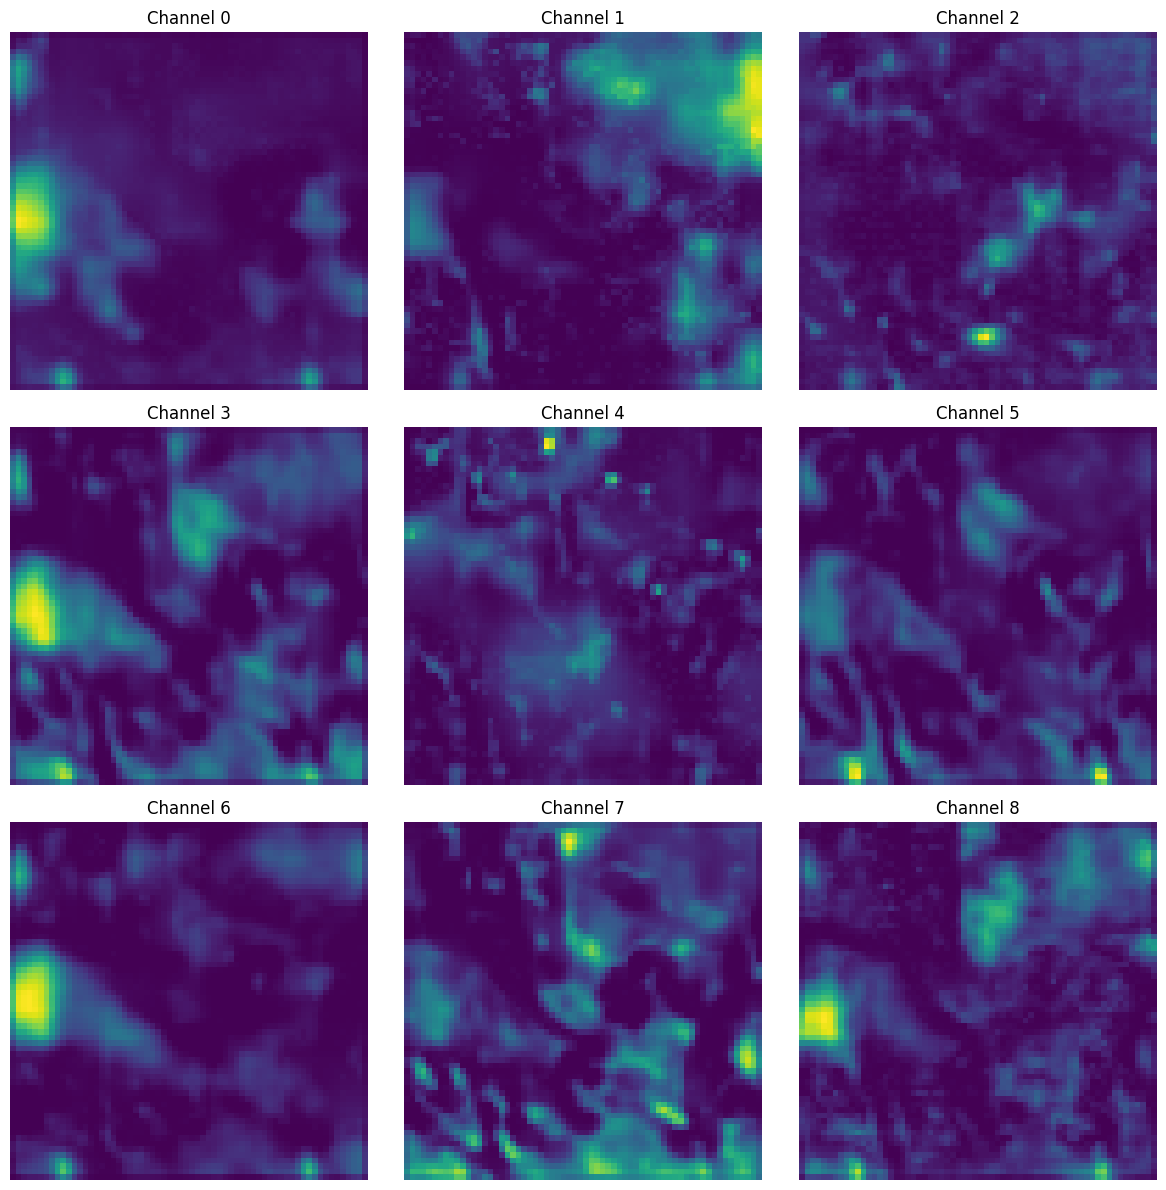

 83%|████████▎ | 5/6 [00:11<00:02,  2.22s/it]

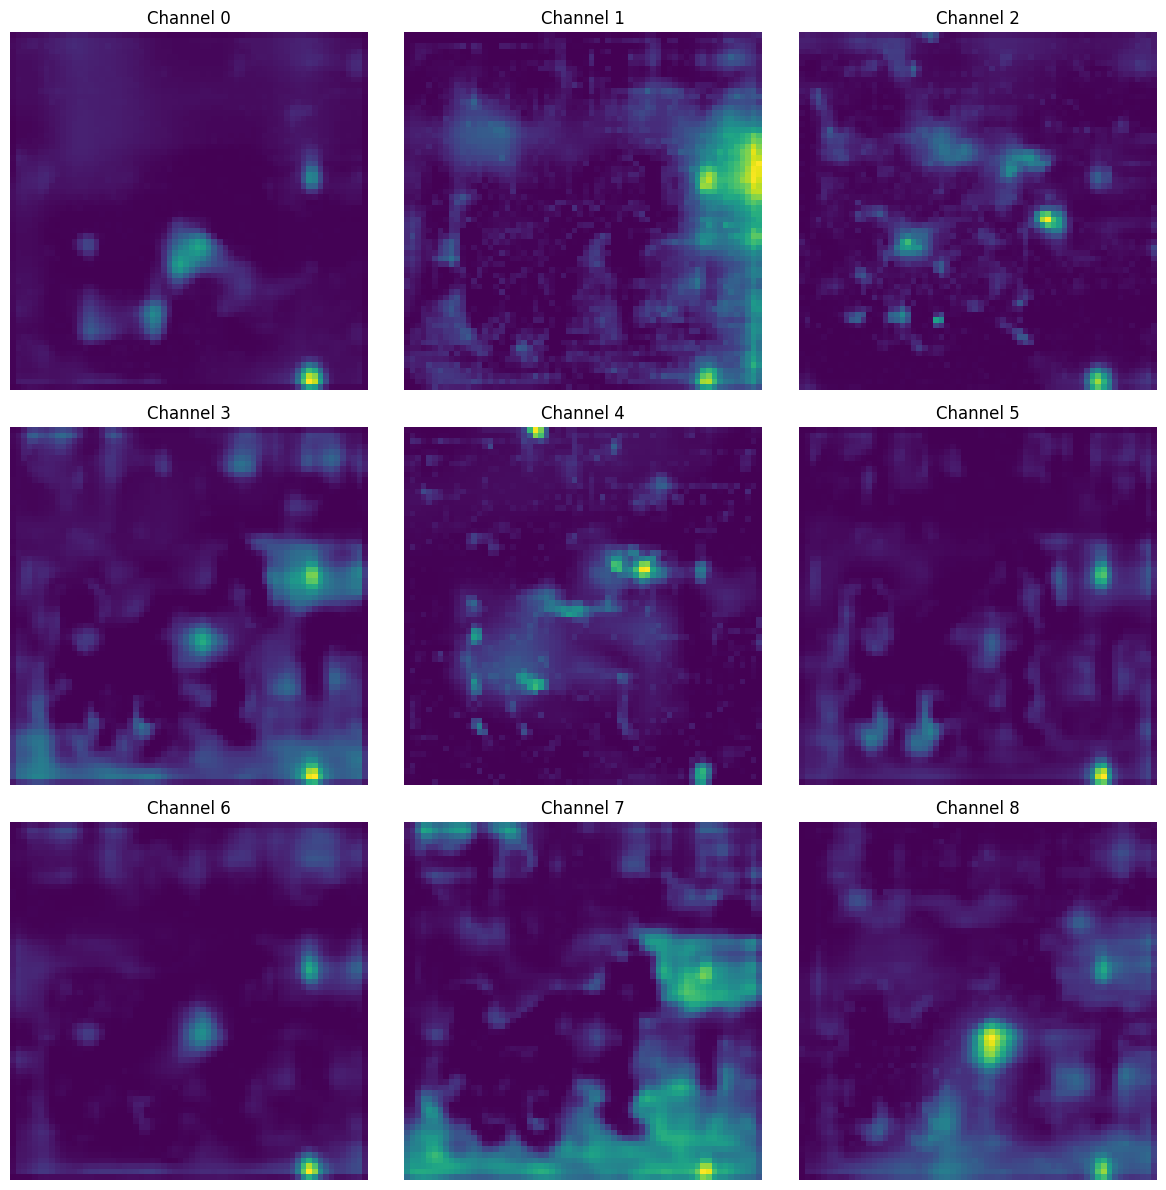

100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


In [57]:
batch_size = config["batch_size"]
print("batch_size:", batch_size)
images_or_prompts = []
if images_or_prompts_path:
    for ann in json.load(open(images_or_prompts_path)):
        if config["diffusion_mode"] == "inversion":
            if type(ann) is dict:
                images_or_prompts.append(f"{image_root}/{ann['source_path']}")
                images_or_prompts.append(f"{image_root}/{ann['target_path']}")
            else:
                images_or_prompts.append(ann)
        elif config["diffusion_mode"] == "generation":
            images_or_prompts.extend([ann] * batch_size)
else:
    images_or_prompts = glob.glob(f"{image_root}/*")

# Duplicate the last item in the list until images_or_prompts is a multiple of batch_size
images_or_prompts = pad_to_batch_size(images_or_prompts, batch_size)
extract_hyperfeats(config, diffusion_extractor, aggregation_network, images_or_prompts, save_root)
